# Model for Disaster tweet classification on Kaggle - [LINK](https://www.kaggle.com/competitions/nlp-getting-started/overview)
# Main Goal : 
> get accuracy above 82.5% on validation data - 15 %
---
Steps:

1. create the datasets
2. create the embedding model
3. create vectorizer for keywords
4. create model with all together
5. train
6. fine tune
7. evaluate
8. repeat experiments
9. create submission

In [1]:
import tensorflow as tf
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt
from config.config import *
from callbacks.callbacks import *
from keras.api.layers import Embedding, TextVectorization

2024-11-15 11:35:40.905096: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 11:35:41.324603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731650741.484949    1007 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731650741.515978    1007 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 11:35:41.760276: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# 1 Creating the datasets

In [2]:
training_df = pd.read_csv(DATA_DIR.joinpath('train.csv'))
training_df.drop(columns=['id', 'location'])#.sample(frac=1, random_state=SEED)

,keyword,text,target
0,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...
7608,NaN,Two giant cranes holding a bridge collapse int...,1
7609,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,NaN,Police investigating after an e-bike collided ...,1


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    training_df[['keyword', 'text']].to_numpy(dtype=np.str_), 
    training_df['target'].to_numpy(),
    shuffle=True,
    test_size=0.2,
    )

In [4]:
pd.Series(y_train).value_counts(), pd.Series(y_val).value_counts()

(0    3461
 1    2629
 Name: count, dtype: int64,
 0    881
 1    642
 Name: count, dtype: int64)

# 2 Create the embedding model

In [5]:
import tensorflow_hub as hub

embedding_layer = hub.KerasLayer(
    "https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
    trainable=False,
    input_shape=[],
    dtype=tf.string,
    name='USE2'
    )
embedding_layer.trainable = False

I0000 00:00:1731650864.728351    1007 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


# 3 Create the text vectorizer

# 4 Create model with all together

In [120]:
inputs = keras.layers.Input(shape=(513,), name='input_layer')

x = keras.layers.Embedding(input_dim=1000, output_dim=16)(inputs[...,0:1])
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(64, activation='relu')(x)
outputs1 = keras.layers.Dense(1, activation='sigmoid')(x)

x = keras.layers.Dense(128, activation='relu')(inputs[...,1:])
x = keras.layers.Dense(32, activation='relu')(x)
outputs2 = keras.layers.Dense(1, activation='sigmoid')(x)

outputs = keras.layers.Average()([outputs1, outputs2])

predictor_ = keras.Model(inputs, outputs)

# 5 Train the model

In [121]:
class Model():

    def __init__(self, vectorizer, embedder, predictor , name : str=''):

        self.vectorizer = vectorizer
        self.embedder = embedder
        self.predictor = keras.models.clone_model(predictor)
        self.predictor.set_weights(predictor.get_weights())
        self.predictor.compile(optimizer = keras.optimizers.Adam(), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
        self.experiment_count = 0 
        self.name = name

    def fit(self, X, y, epochs, validation_data, batch_size=BATCH_SIZE, initial_epoch=0):

        Xt, yt = validation_data

        x1 = X[...,0]
        x2 = X[...,1]
        tx1 = Xt[...,0]
        tx2 = Xt[...,1]

        self.vectorizer.adapt(x1)
        vx = self.vectorizer(x1)
        ex = self.embedder(x2)
        tvx = self.vectorizer(tx1)
        tex = self.embedder(tx2)
        tX = np.concatenate((vx, ex),axis=-1)
        ttX = np.concatenate((tvx, tex),axis=-1)
                
        tbcallback = create_tensorboard_callback(self.name, f'RUN{self.experiment_count}')
        history = self.predictor.fit(
            tX, 
            y, 
            epochs=epochs, 
            validation_data=(ttX, yt), 
            batch_size=batch_size, 
            initial_epoch=initial_epoch, 
            callbacks=[tbcallback]
        )
        self.experiment_count +=1
        return history

    def predict(self, X):

        x1 = X[...,0]
        x2 = X[...,1]
        vx = self.vectorizer(x1)
        ex = self.embedder(x2)
        tX = np.concatenate((vx, ex),axis=-1)
        return self.predictor.predict(tX)

In [122]:
model_0 = Model(
    TextVectorization(max_tokens=1000, output_sequence_length=1),
    embedding_layer,
    predictor_
)

In [123]:
history_0 = model_0.fit(
    X_train,
    y_train,
    epochs=25,
    validation_data = (X_val, y_val)
)

Saving log files to : /home/yehand/.vscode-server/projects/NLP/experiments/RUN0
Epoch 1/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7184 - loss: 0.5960 - val_accuracy: 0.8129 - val_loss: 0.4332
Epoch 2/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8284 - loss: 0.4225 - val_accuracy: 0.8332 - val_loss: 0.4162
Epoch 3/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8469 - loss: 0.3875 - val_accuracy: 0.8273 - val_loss: 0.4175
Epoch 4/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8515 - loss: 0.3747 - val_accuracy: 0.8293 - val_loss: 0.4156
Epoch 5/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8663 - loss: 0.3537 - val_accuracy: 0.8299 - val_loss: 0.4172
Epoch 6/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8700 - loss: 0.3503 - val_accuracy: 0.8313 - val_loss: 0.4232
Epoch 7/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8814 - loss: 0.3341 - val_accuracy: 0.8339 - val_loss: 0.4255
Epoch 8/25
191/191 ━━━━

<Axes: >

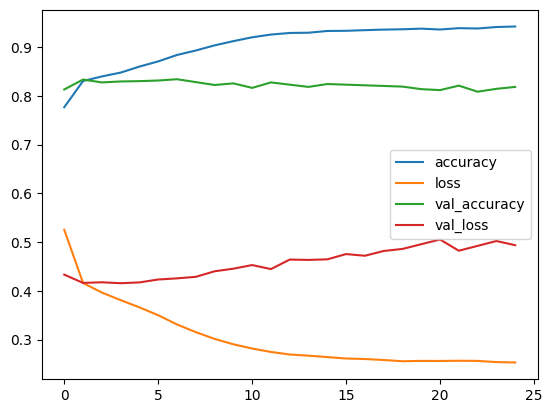

In [124]:
pd.DataFrame(history_0.history).plot()

# Model is over fitting let's add dropouts

In [125]:
inputs = keras.layers.Input(shape=(513,), name='input_layer')

x = keras.layers.Embedding(input_dim=1000, output_dim=16)(inputs[...,0:1])
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs1 = keras.layers.Dense(1, activation='sigmoid')(x)

x = keras.layers.Dense(128, activation='relu')(inputs[...,1:])
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs2 = keras.layers.Dense(1, activation='sigmoid')(x)

outputs = keras.layers.Average()([outputs1, outputs2])

predictor_1 = keras.Model(inputs, outputs)

In [126]:
model_1 = Model(
    TextVectorization(max_tokens=1000, output_sequence_length=1),
    embedding_layer,
    predictor_1,
    name='model_1_Dropout'
)

In [127]:
history_1 = model_1.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data = (X_val, y_val)
)

Saving log files to : /home/yehand/.vscode-server/projects/NLP/experiments/model_1_Dropout/RUN0
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6828 - loss: 0.6295 - val_accuracy: 0.8116 - val_loss: 0.4511
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8099 - loss: 0.4448 - val_accuracy: 0.8214 - val_loss: 0.4188
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8324 - loss: 0.4141 - val_accuracy: 0.8162 - val_loss: 0.4186
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8284 - loss: 0.4009 - val_accuracy: 0.8293 - val_loss: 0.4171
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8391 - loss: 0.3994 - val_accuracy: 0.8247 - val_loss: 0.4200
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8454 - loss: 0.3813 - val_accuracy: 0.8181 - val_loss: 0.4238
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8482 - loss: 0.3809 - val_accuracy: 0.8240 - val_loss: 0.4213
Epoc

In [128]:
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Add a data cleaning step

In [129]:
model_1.vectorizer.get_vocabulary()
# Looks like nothing to clean in keys

['',
 '[UNK]',
 'nan',
 'oil20spill',
 'sunk',
 'outbreak',
 'fear',
 'fatalities',
 'armageddon',
 'siren',
 'massacre',
 'fatal',
 'emergency',
 'damage',
 'collision',
 'typhoon',
 'thunder',
 'earthquake',
 'drowned',
 'desolation',
 'attack',
 'ruin',
 'razed',
 'pandemonium',
 'hail',
 'flooding',
 'flood',
 'explode',
 'derailment',
 'debris',
 'collided',
 'collapsed',
 'bombed',
 'blizzard',
 'ambulance',
 'wrecked',
 'wreckage',
 'wounded',
 'weapon',
 'violent20storm',
 'traumatised',
 'sinking',
 'rescued',
 'nuclear20reactor',
 'lava',
 'inundated',
 'harm',
 'fire',
 'famine',
 'drowning',
 'deluge',
 'danger',
 'body20bags',
 'blaze',
 'attacked',
 'ablaze',
 'weapons',
 'twister',
 'tragedy',
 'stretcher',
 'riot',
 'police',
 'injuries',
 'hurricane',
 'fire20truck',
 'detonate',
 'destroy',
 'demolish',
 'deaths',
 'curfew',
 'crashed',
 'catastrophe',
 'bleeding',
 'windstorm',
 'tornado',
 'terrorism',
 'screams',
 'screaming',
 'refugees',
 'rainstorm',
 'panic',
 

In [130]:
Index = 10
num_samples= 10
X_train[...,1][Index: Index+num_samples], y_train[Index: Index+num_samples]

(array(['This is my jam: Riser by Dierks Bentley ? #iHeartRadio #NowPlaying',
        "Roger Goodell's Fatal Mistake: Tom Brady An Innocent Man",
        'Again?? Eep! Thought of you yesterday when I saw that hella scary hail. #armageddon?',
        "Lol The real issue is the the way the NFL is trying to ruin this guy's legacy. https://t.co/s107ee7CYC",
        '0-day bug in fully patched OS X comes under active exploit to bypass password ... - Ars Technica',
        "'So again make sure to evacuate past the fire doors. Any questions? Yes?' 'Why would we open the doors to the fire!!?!??!?' I...I..I cant",
        'Guaranteed been bitten by some mutant mosquito my ankle has blown up. Little cunts',
        "that's not my take from his piece. Not putting that ambition in check will destroy the change we voted for the change we seek",
        'Tension In Bayelsa As Patience Jonathan Plans To Hijack APC PDP',
        'WE COULD HAVE HAD IT AAAAAAALLLL I\x89Ûªm not even on that season and I\

We can remove the twitter links and the mentions of other users

methods - we can split all sentences and remove words starting with ' http://t.co' and remove all words starting with '@'

possible errors - we might remove useful words that start with these prefixes but it might be very rare

In [131]:
def clean(dataset):
    cleaned = []
    for i in range(len(dataset)) :
        sentence = []
        print(dataset[i].split())
        for word in dataset[i].split():
            if word[0] == '@' or word[:12] == 'https://t.co':
                pass
            else:
                sentence.append(word)
        cleaned.append(' '.join(sentence))
    return np.array(cleaned)

In [132]:
Index = 350
num_samples= 10
X_train[...,1][Index: Index+num_samples], y_train[Index: Index+num_samples], clean(X_train[...,1][Index: Index+num_samples])

["I've", 'been', 'bleeding', 'in', 'your', 'silence', 'I', 'feel', 'safer', 'in', 'your', 'violence', '.']
['I', 'totally', 'agree.', 'They', 'rape', 'kill', 'destroy', 'and', 'leave', 'land', 'desolate.', 'Action', 'needs', 'to', 'happen', 'before', 'the', 'swarm', 'swells.', 'https://t.co/Twcds433YI']
['A', 'sandstorm', 'in', 'Jordan', 'has', 'coated', 'the', 'Middle', 'East\x89Ûªs', 'largest', 'refugee', 'camp', 'in', 'a', 'layer', 'of', 'grit']
['New', 'music', 'from', 'featuring', 'M.O.P.?', "'Detonate'", 'taken', 'off', 'his', 'album', "'Grandeur'", 'coming', 'soon', '-']
['I', "can't", 'listen', 'to', 'Darude', 'Sandstorm', 'without', 'expecting', 'airhorns', 'now']
['White', 'people', 'I', 'know', 'you', 'worry', 'tirelessly', 'about', 'black', 'on', 'black', 'crime', 'but', 'what', 'are', 'you', 'going', 'to', 'do', 'about', 'your', 'mass', 'murderer', 'problem?']
['2', 'hostages', 'in', 'Libya', 'remain', 'unharmed:', 'Government', 'sources', 'on', 'Wednesday', 'denied', 'rep

(array(["I've been bleeding in your silence I feel safer in your violence .",
        'I totally agree. They rape kill destroy and leave land desolate. Action needs to happen before the swarm swells. https://t.co/Twcds433YI',
        'A sandstorm in Jordan has coated the Middle East\x89Ûªs largest refugee camp in a layer of grit',
        "New music from featuring M.O.P.? 'Detonate' taken off his album 'Grandeur' coming soon -",
        "I can't listen to Darude Sandstorm without expecting airhorns now",
        'White people I know you worry tirelessly about black on black crime but what are you going to do about your mass murderer problem?',
        '2 hostages in Libya remain unharmed: Government sources on Wednesday denied reports that two Indian nationals who\x89Û_',
        'Mourning notices for stabbing arson victims stir \x89Û÷politics of grief\x89Ûª in Israel',
        '11 soldiers killed in ISIS suicide bomb in air base east Homs SYRIA NEWS | ZAMAN ALWSL - #ISIS #Homs',
     

In [ ]:
class Model():

    def __init__(self, vectorizer, embedder, predictor , name : str=''):

        self.vectorizer = vectorizer
        self.embedder = embedder
        self.predictor = keras.models.clone_model(predictor)
        self.predictor.set_weights(predictor.get_weights())
        self.predictor.compile(optimizer = keras.optimizers.Adam(), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
        self.experiment_count = 0 
        self.name = name

    def fit(self, X, y, epochs, validation_data, batch_size=BATCH_SIZE, initial_epoch=0):
        Xt, y_val = validation_data

        x1 = X[...,0]

        self.vectorizer.adapt(x1)
       
        X_val = self.transform(Xt)

        X_train = self.transform(X)
                
        tbcallback = create_tensorboard_callback(self.name, f'RUN{self.experiment_count}')
        history = self.predictor.fit(
            X_train, 
            y, 
            epochs=epochs, 
            validation_data=(X_val, y_val), 
            batch_size=batch_size, 
            initial_epoch=initial_epoch, 
            callbacks=[tbcallback],
        )
        self.experiment_count +=1
        return history

    def predict(self, X):

        transformed = self.transform(X)
        return self.predictor.predict(transformed)
    
    def clean(self, text):
        cleaned = []
        for i in range(len(text)) :
            sentence = []
            for word in text[i].split():
                if word[0] == '@' or word[:12] == 'https://t.co':
                    pass
                else:
                    sentence.append(word)
            cleaned.append(' '.join(sentence))
        return np.array(cleaned)
    
    def transform(self, X):

        x1 = X[...,0]
        x2 = X[...,1]
        x2 = self.clean(x2)
        vx = self.vectorizer(x1)
        ex = self.embedder(x2)
        return np.concatenate((vx, ex),axis=-1)

## Testing with same architecture

In [145]:
model_2 = Model(
    TextVectorization(max_tokens=1000, output_sequence_length=1),
    embedding_layer,
    predictor_1,
    name='model_2_Dropout+Clean'
)

In [146]:
history_2 = model_2.fit(
    X_train,
    y_train,
    epochs=5,
    validation_data = (X_val, y_val)
)

[ True False False ...  True False  True]
[ True  True  True ...  True  True  True]
Saving log files to : /home/yehand/.vscode-server/projects/NLP/experiments/model_2_Dropout+Clean/RUN0
Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.6955 - loss: 0.6316 - val_accuracy: 0.8116 - val_loss: 0.4649
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8158 - loss: 0.4565 - val_accuracy: 0.8299 - val_loss: 0.4195
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8211 - loss: 0.4145 - val_accuracy: 0.8319 - val_loss: 0.4190
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8372 - loss: 0.3943 - val_accuracy: 0.8221 - val_loss: 0.4205
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8448 - loss: 0.3812 - val_accuracy: 0.8273 - val_loss: 0.4217


In [160]:
# Performance seems good
# Checking custom samples
data = np.array([
    ['wounded', 'people wounded in airplane crash some might be dead'],
    ['cool', 'the new tesla robot is cool af #tesla']
])
np.round(model_2.predict(data)).astype(np.int16)

[ True  True]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


array([[1],
       [0]], dtype=int16)

# Creating Submission File

In [162]:
test_df = pd.read_csv(DATA_DIR.joinpath('test.csv'))
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [163]:
ids = test_df['id']
test_df = test_df[['keyword','text']].to_numpy(dtype=np.str_)
ids.head(), test_df[:5]

(0     0
 1     2
 2     3
 3     9
 4    11
 Name: id, dtype: int64,
 array([['nan', 'Just happened a terrible car crash'],
        ['nan',
         'Heard about #earthquake is different cities, stay safe everyone.'],
        ['nan',
         'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all'],
        ['nan', 'Apocalypse lighting. #Spokane #wildfires'],
        ['nan', 'Typhoon Soudelor kills 28 in China and Taiwan']],
       dtype='<U151'))

In [164]:
test_preds = np.squeeze(np.round(model_2.predict(test_df)).astype(np.int32))
test_preds[:5]

[ True  True  True ...  True  True  True]
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


array([1, 1, 1, 1, 1], dtype=int32)

In [178]:
submission_df = pd.DataFrame(data={
    'id' : ids,
    'target' : test_preds
})
submission_df.set_index('id', inplace=True)


In [179]:
submission_df.to_csv(DATA_DIR.joinpath('Submission1.csv'))